In [7]:
%load_ext autoreload
%autoreload 2
import os
os.environ['OMP_NUM_THREADS'] = '33'
from utils_folding import SimulationParticles
import matplotlib.pyplot as plt
plt.style.use('niceplot2jay.mplstyle')

SNAPSHOT = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind0_gmc9/snapshot_550.hdf5'
simParticles = SimulationParticles.load_snapshot(SNAPSHOT)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**First Idea** Adaptive smoothing according to density. **Issue 1** : it cannot guarantee to fill all empty cells. **Issue 2** : more costly with voxelize when particle overlap increases.

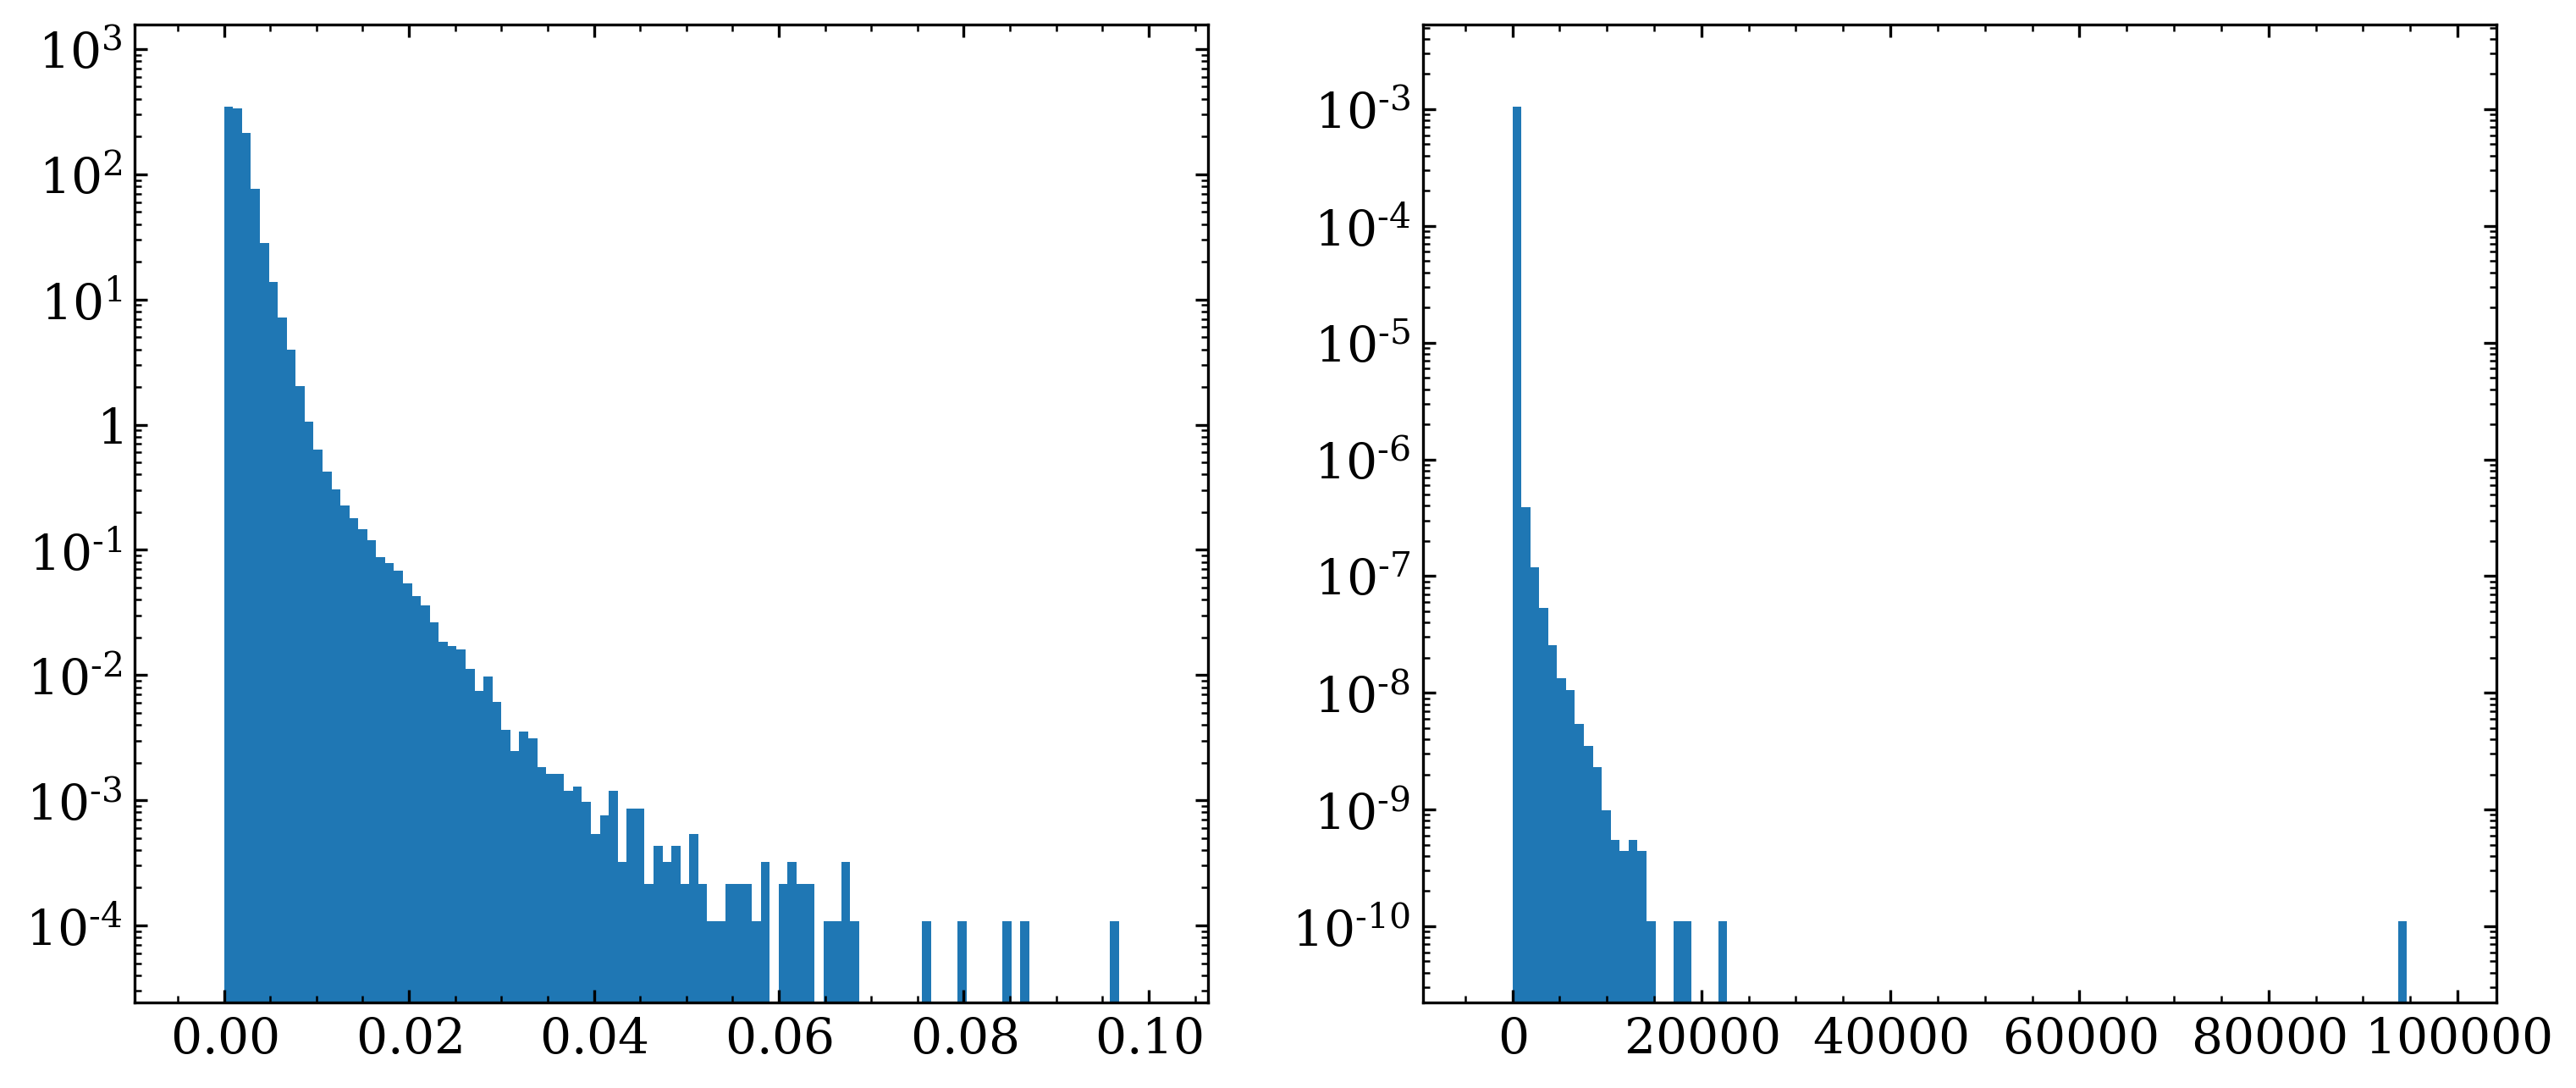

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(simParticles.h(), bins=100, log=True, density=True)
ax[1].hist(simParticles.density, bins=100, log=True, density=True)
plt.show()

In [53]:
import numpy as np
min = 1
max = 3.5
max_rho = np.max(simParticles.density)
min_rho = np.min(simParticles.density)
mean_rho = np.mean(simParticles.density)
sigma_rho = np.std(simParticles.density)
print(max_rho, min_rho, mean_rho, sigma_rho)
shifted_gaussian = lambda x: np.exp(-(x - max_rho)**2/(2*(100000**2))) * (max - min) + min
adaptive_smoothing_rate = shifted_gaussian(simParticles.density)

94646.63716740119 2.0811863236634787e-07 2.6780986250716996 73.98185168185337


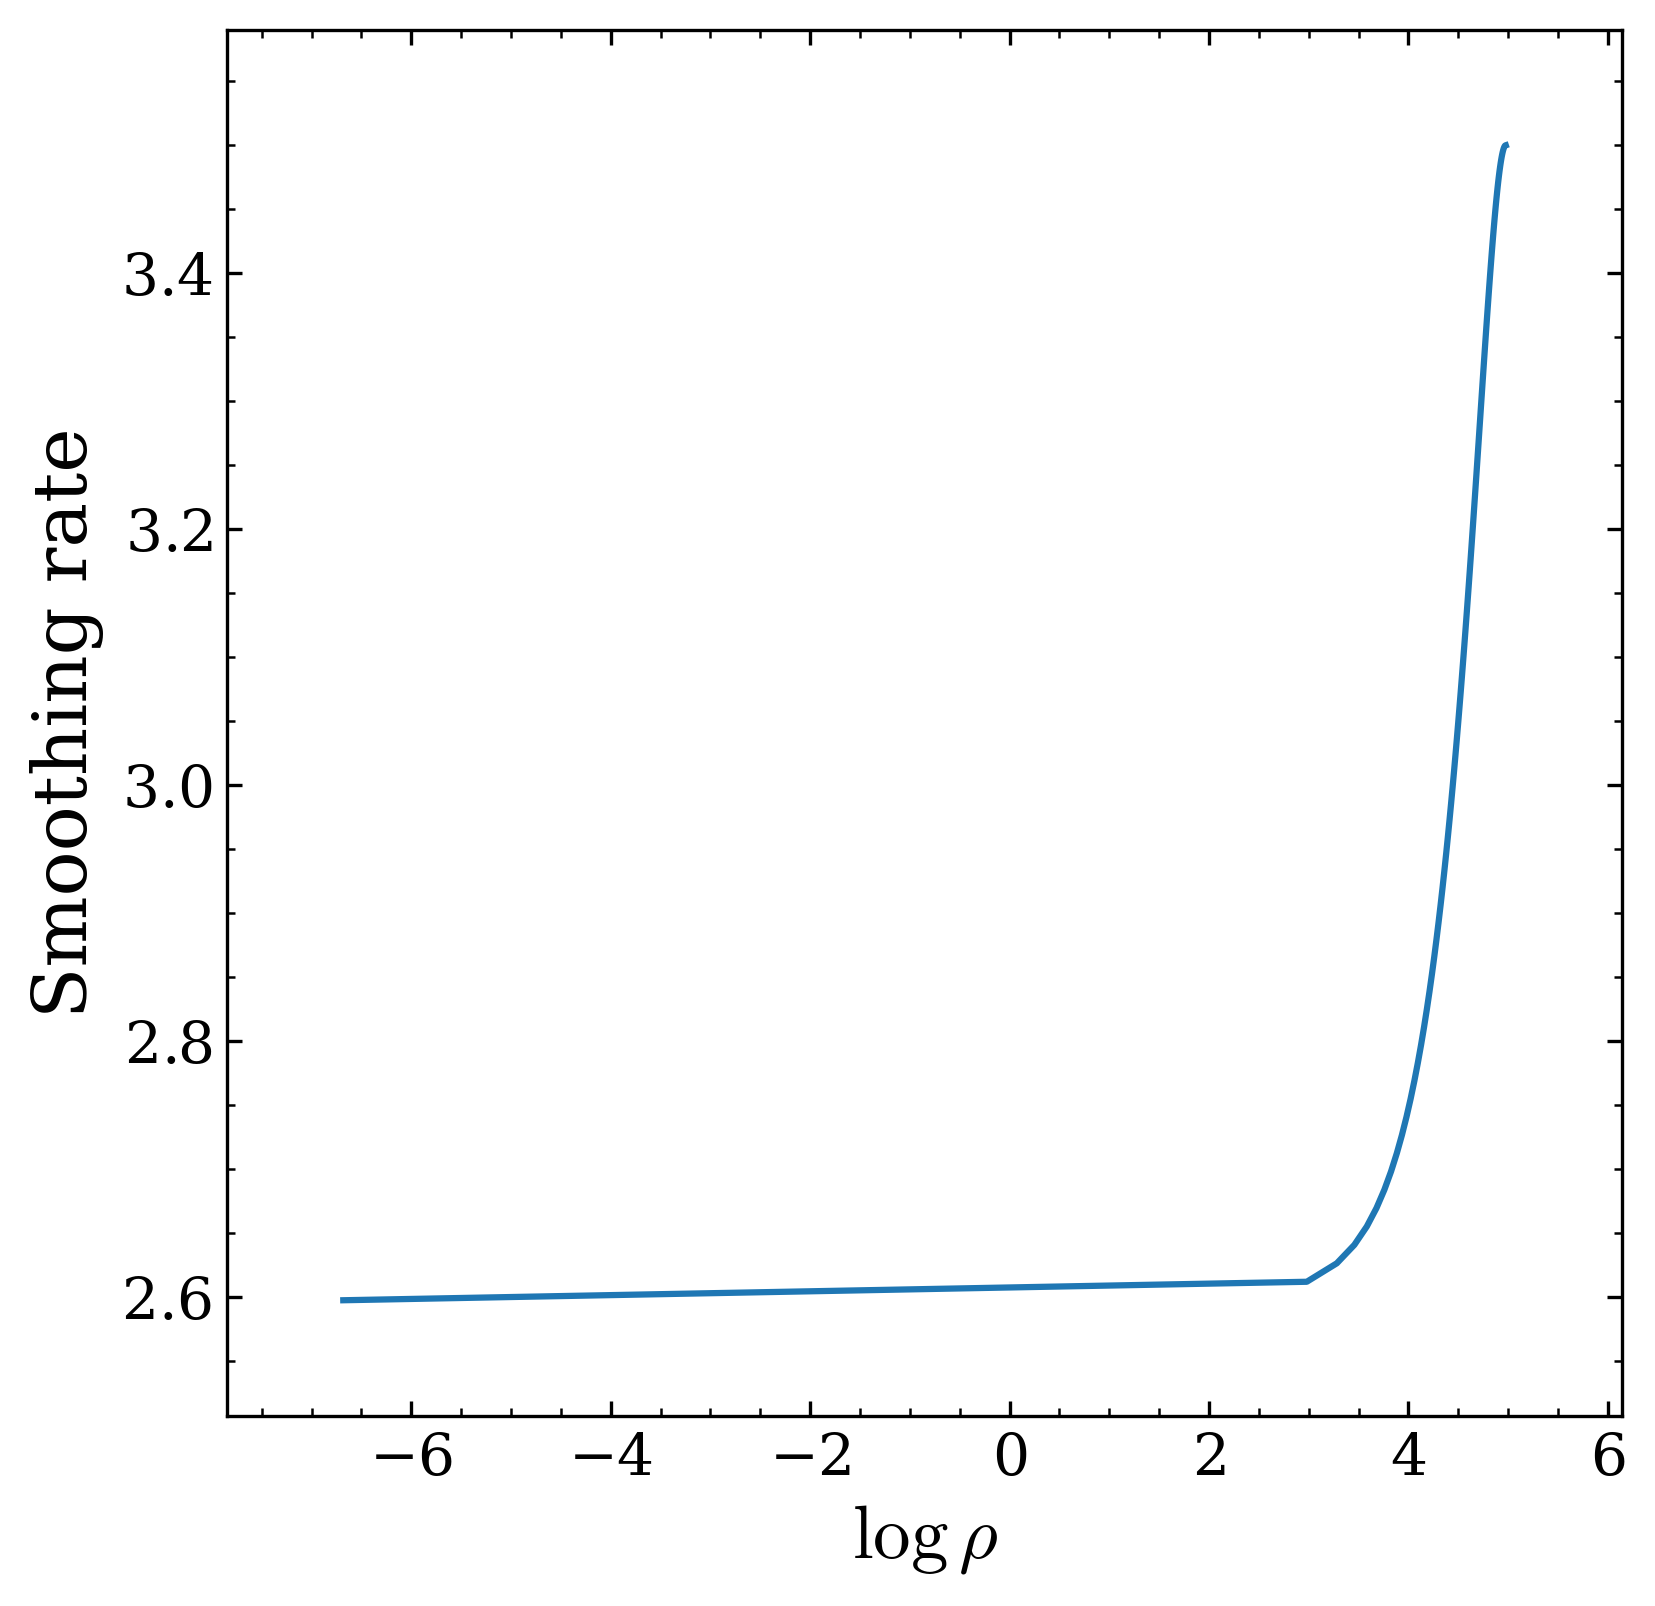

In [36]:
x = np.linspace(min_rho, max_rho, 100)
plt.plot(np.log10(x), shifted_gaussian(x))
plt.xlabel("$\\log\\rho$")
plt.ylabel("Smoothing rate")
plt.show()

In [8]:
simField = simParticles.interp_to_field(Nsize=512, smoothing_rate=adaptive_smoothing_rate)

NameError: name 'adaptive_smoothing_rate' is not defined

In [55]:
zeros = simField.vx[simField.vx==0]
print(len(zeros), "of", len(simField.vx.flatten()), "are zero")

3485 of 134217728 are zero


In [53]:
np.min(simParticles.h()), 1/16384

(2.6054275452966415e-06, 6.103515625e-05)

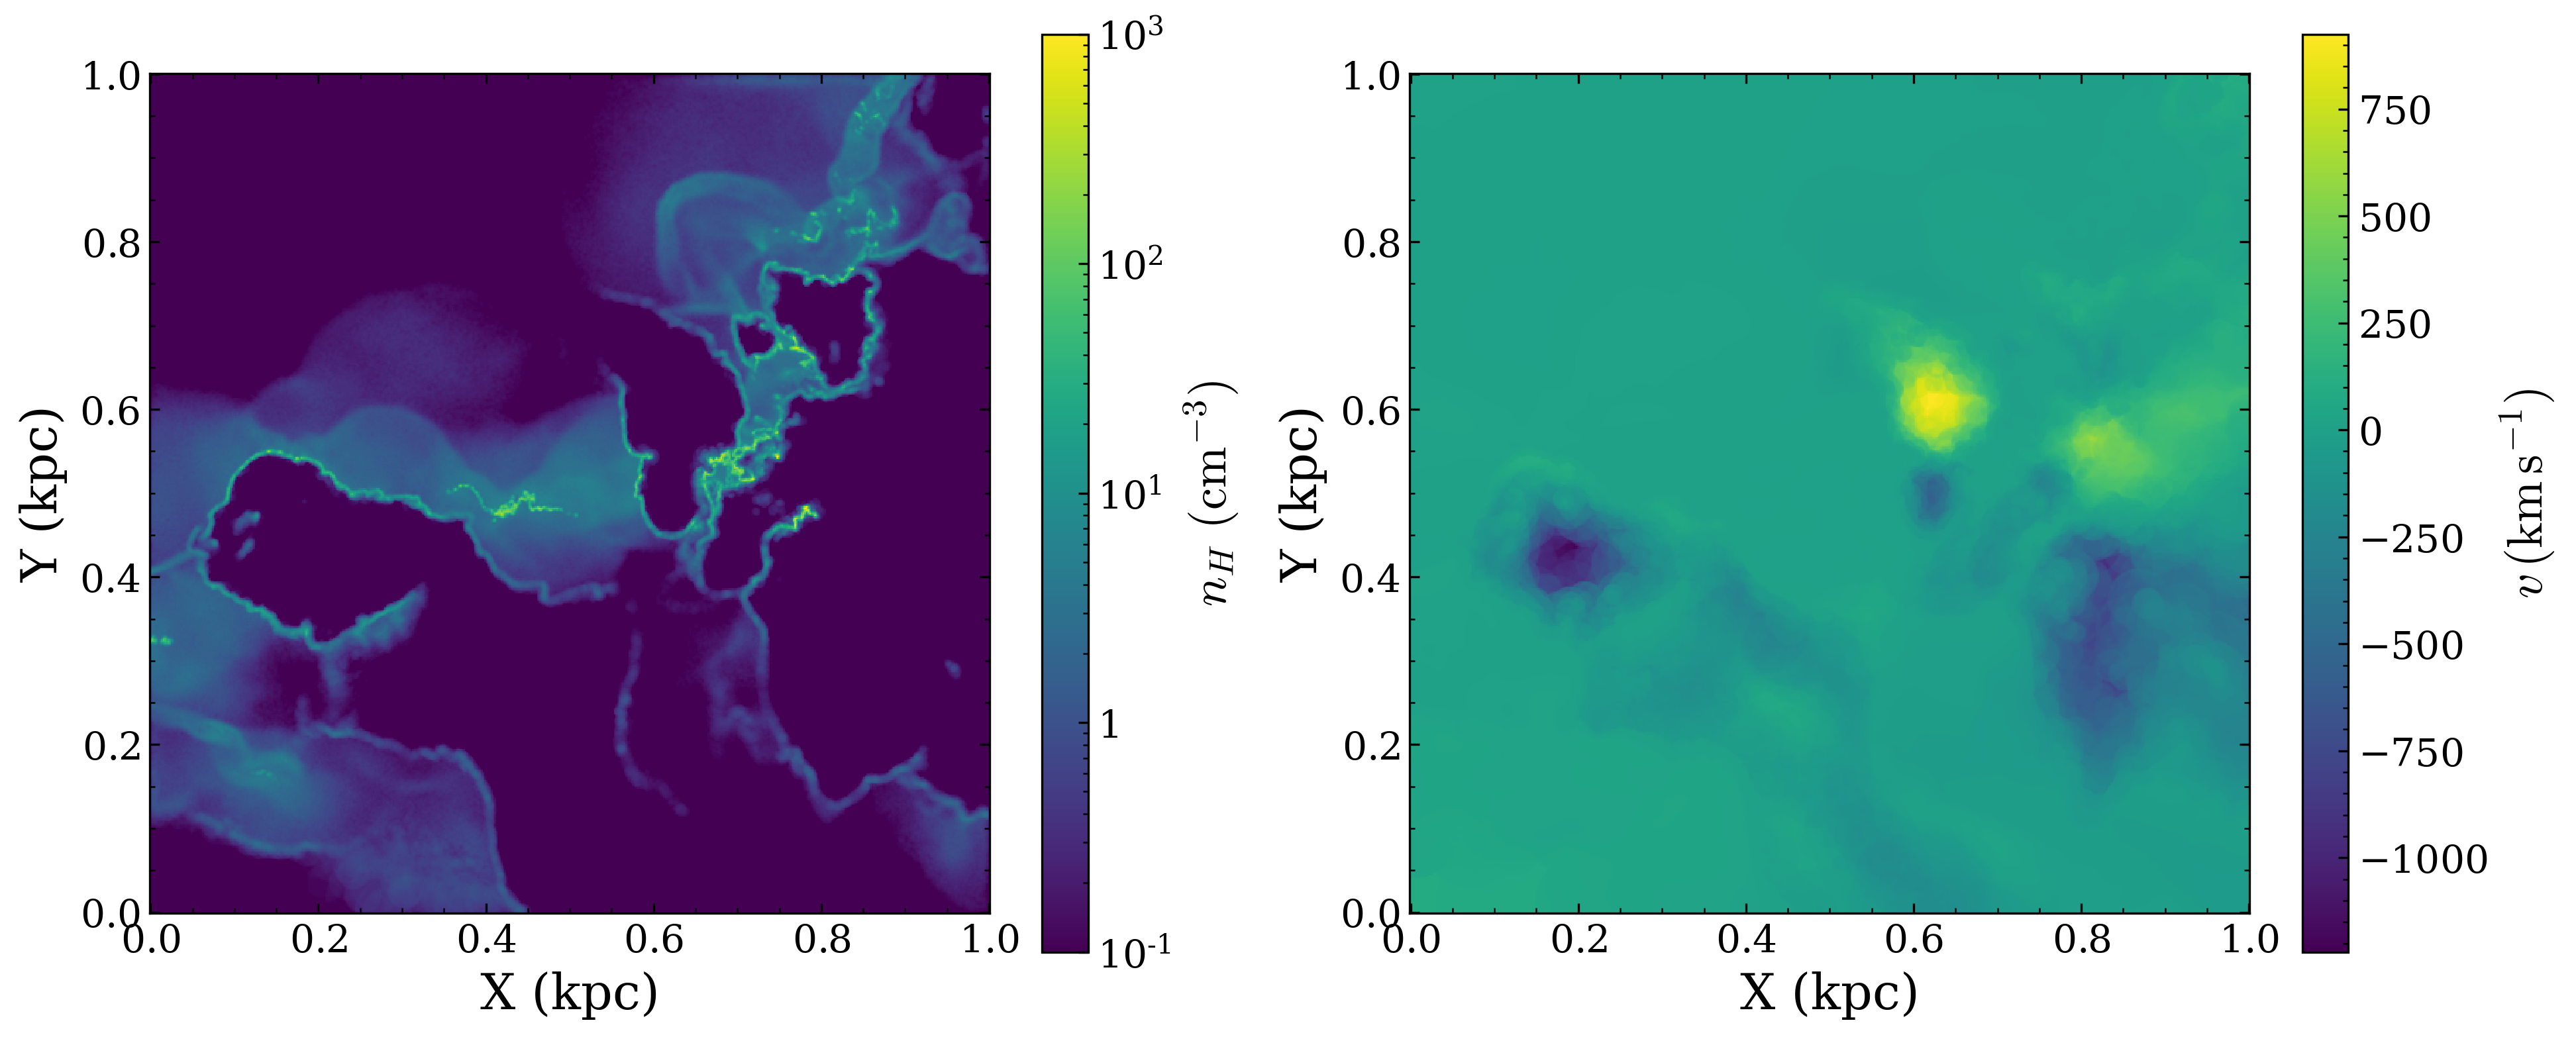

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
simField.plot_density_slice(index=256, axis=2, ax=ax[0])
simField.plot_velocity_slice(component=0, index=256, axis=2, ax=ax[1])
plt.show()

Show a `smoothing_rate = 1.` case. **Issue** : voxelize could cause the edge
of a particle/cloud to fall off. This is not a problem for velocity here when we
need only the divided value where the fall-off of momentum and mass would cancel out.

In [9]:
# Interpolate with no smoothing
simField = simParticles.interp_to_field(Nsize=256, smoothing_rate=1.)

# Count empty pixels
zeros = simField.vx[simField.vx==0]
print(len(zeros), "of", len(simField.vx.flatten()), "are zero")

Interpolating velocity field...
Padding:  0.035411309549151726 Lbox:  1.0708226190983035 Nsize:  274
Auto padding done. Time elapsed: 1.47 s


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 32 threads.
Workers processed 86407227 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	8.066e+07 exact calculations (R>Rmax),
	5.748e+06 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 86407227 numbers in 2655 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 12.8248 seconds
In the end, 0 in cpu_queue


Interpolation done. Time elapsed: 15.17 s
1442245 of 16777216 are zero


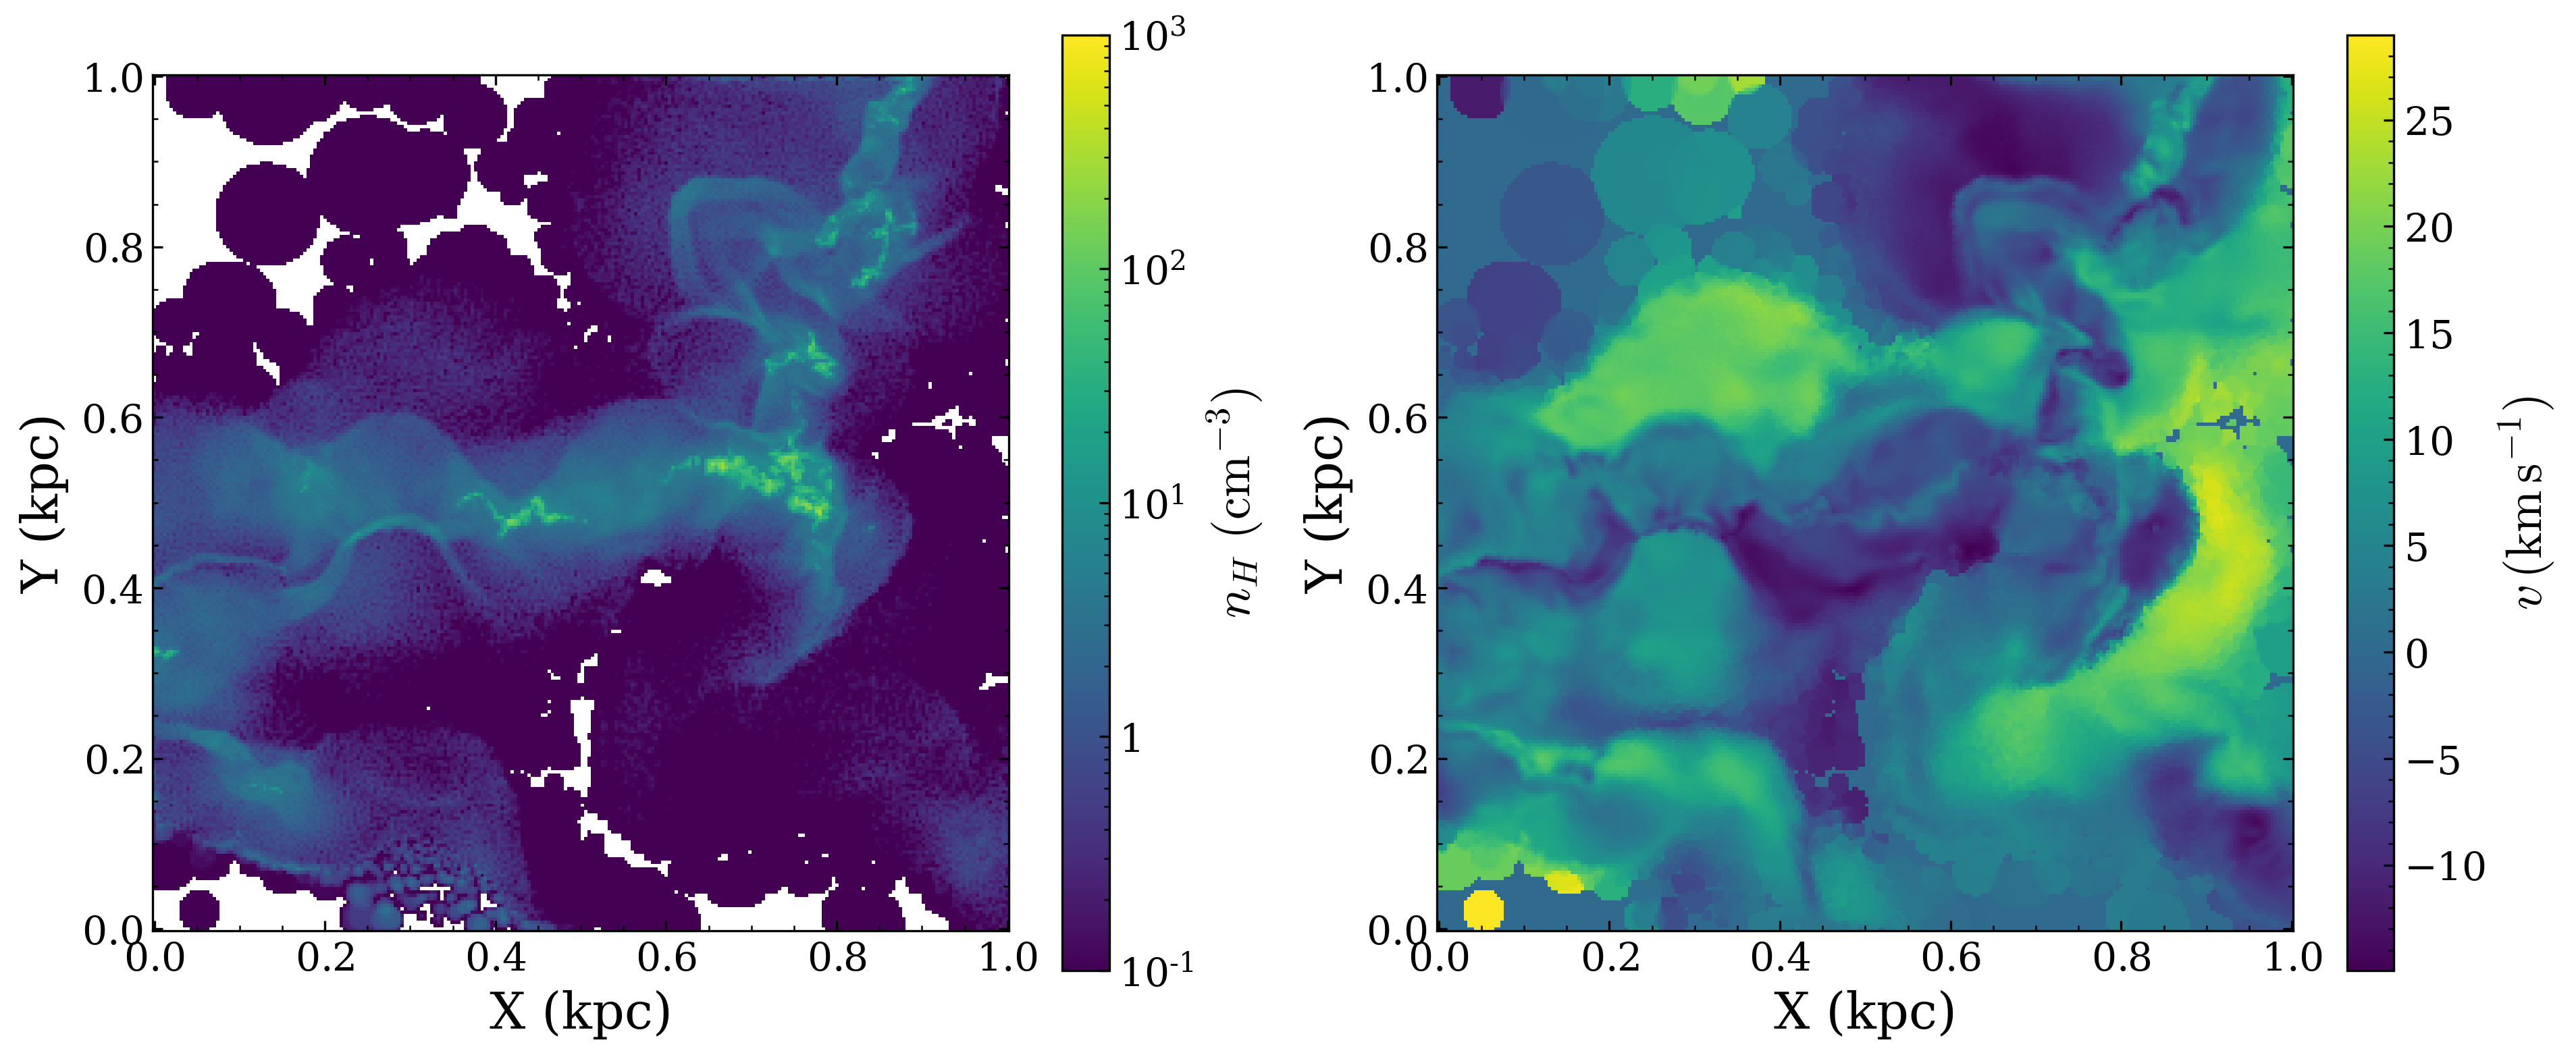

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
simField.plot_density_slice(index=128, axis=2, ax=ax[0])
simField.plot_velocity_slice(component=2, index=128, axis=2, ax=ax[1])
plt.show()

**Dark Art** : nearest interpolator after voxelize

In [4]:
# First idea: use the filled cells to interpolate.
# Issue: low efficiency.
from scipy.interpolate import NearestNDInterpolator
import numpy as np
def nearest_fill_empty(field, Nsize):
  values = np.ravel(field)

  X = np.linspace(0, 1, Nsize)
  Y = np.linspace(0, 1, Nsize)
  Z = np.linspace(0, 1, Nsize)
  X, Y, Z = np.meshgrid(X, Y, Z, indexing='ij')
  pos = np.stack((np.ravel(X), np.ravel(Y), np.ravel(Z)), axis=1)

  # Interpolate
  interpolator = NearestNDInterpolator(pos[values != 0], values[values != 0])
  filling = interpolator(pos[values == 0])
  print("Empty voxels to be filled : {}".format(len(filling)))

  # Fill the empty values
  values[values == 0] = filling
  filled = np.reshape(values, (Nsize, Nsize, Nsize))
  print("Empty voxels after filling : {}".format(len(filled[filled == 0])))

  return filled

# Another way: filling with particle information. To reduce the size of tree and 
# increace efficiency.
def nearest_fill_empty_by_particles(field, Nsize, particle_pos, particle_values):

  field_values = np.ravel(field)

  X = np.linspace(0, 1, Nsize)
  Y = np.linspace(0, 1, Nsize)
  Z = np.linspace(0, 1, Nsize)
  X, Y, Z = np.meshgrid(X, Y, Z, indexing='ij')
  field_pos = np.stack((np.ravel(X), np.ravel(Y), np.ravel(Z)), axis=1)

  # Interpolate
  interpolator = NearestNDInterpolator(particle_pos, particle_values)
  filling = interpolator(field_pos[field_values == 0])
  print("Empty voxels to be filled : {}".format(len(filling)))

  # Fill the empty values
  field_values[field_values == 0] = filling
  filled = np.reshape(field_values, (Nsize, Nsize, Nsize))
  print("Empty voxels after filling : {}".format(len(filled[filled == 0])))

  return filled

In [5]:
# Fill density and vx fields
filled_density = nearest_fill_empty_by_particles(simField.density(), 512, 
                                                 simParticles.pos, simParticles.density)
filled_vx = nearest_fill_empty_by_particles(simField.vx, 512, simParticles.pos, 
                                            simParticles.v[:,0])
# filled_density = nearest_fill_empty(simField.density(), 512)
# filled_vx = nearest_fill_empty(simField.vx, 512)

Empty voxels to be filled : 16914860
Empty voxels after filling : 0
Empty voxels to be filled : 16914860
Empty voxels after filling : 0


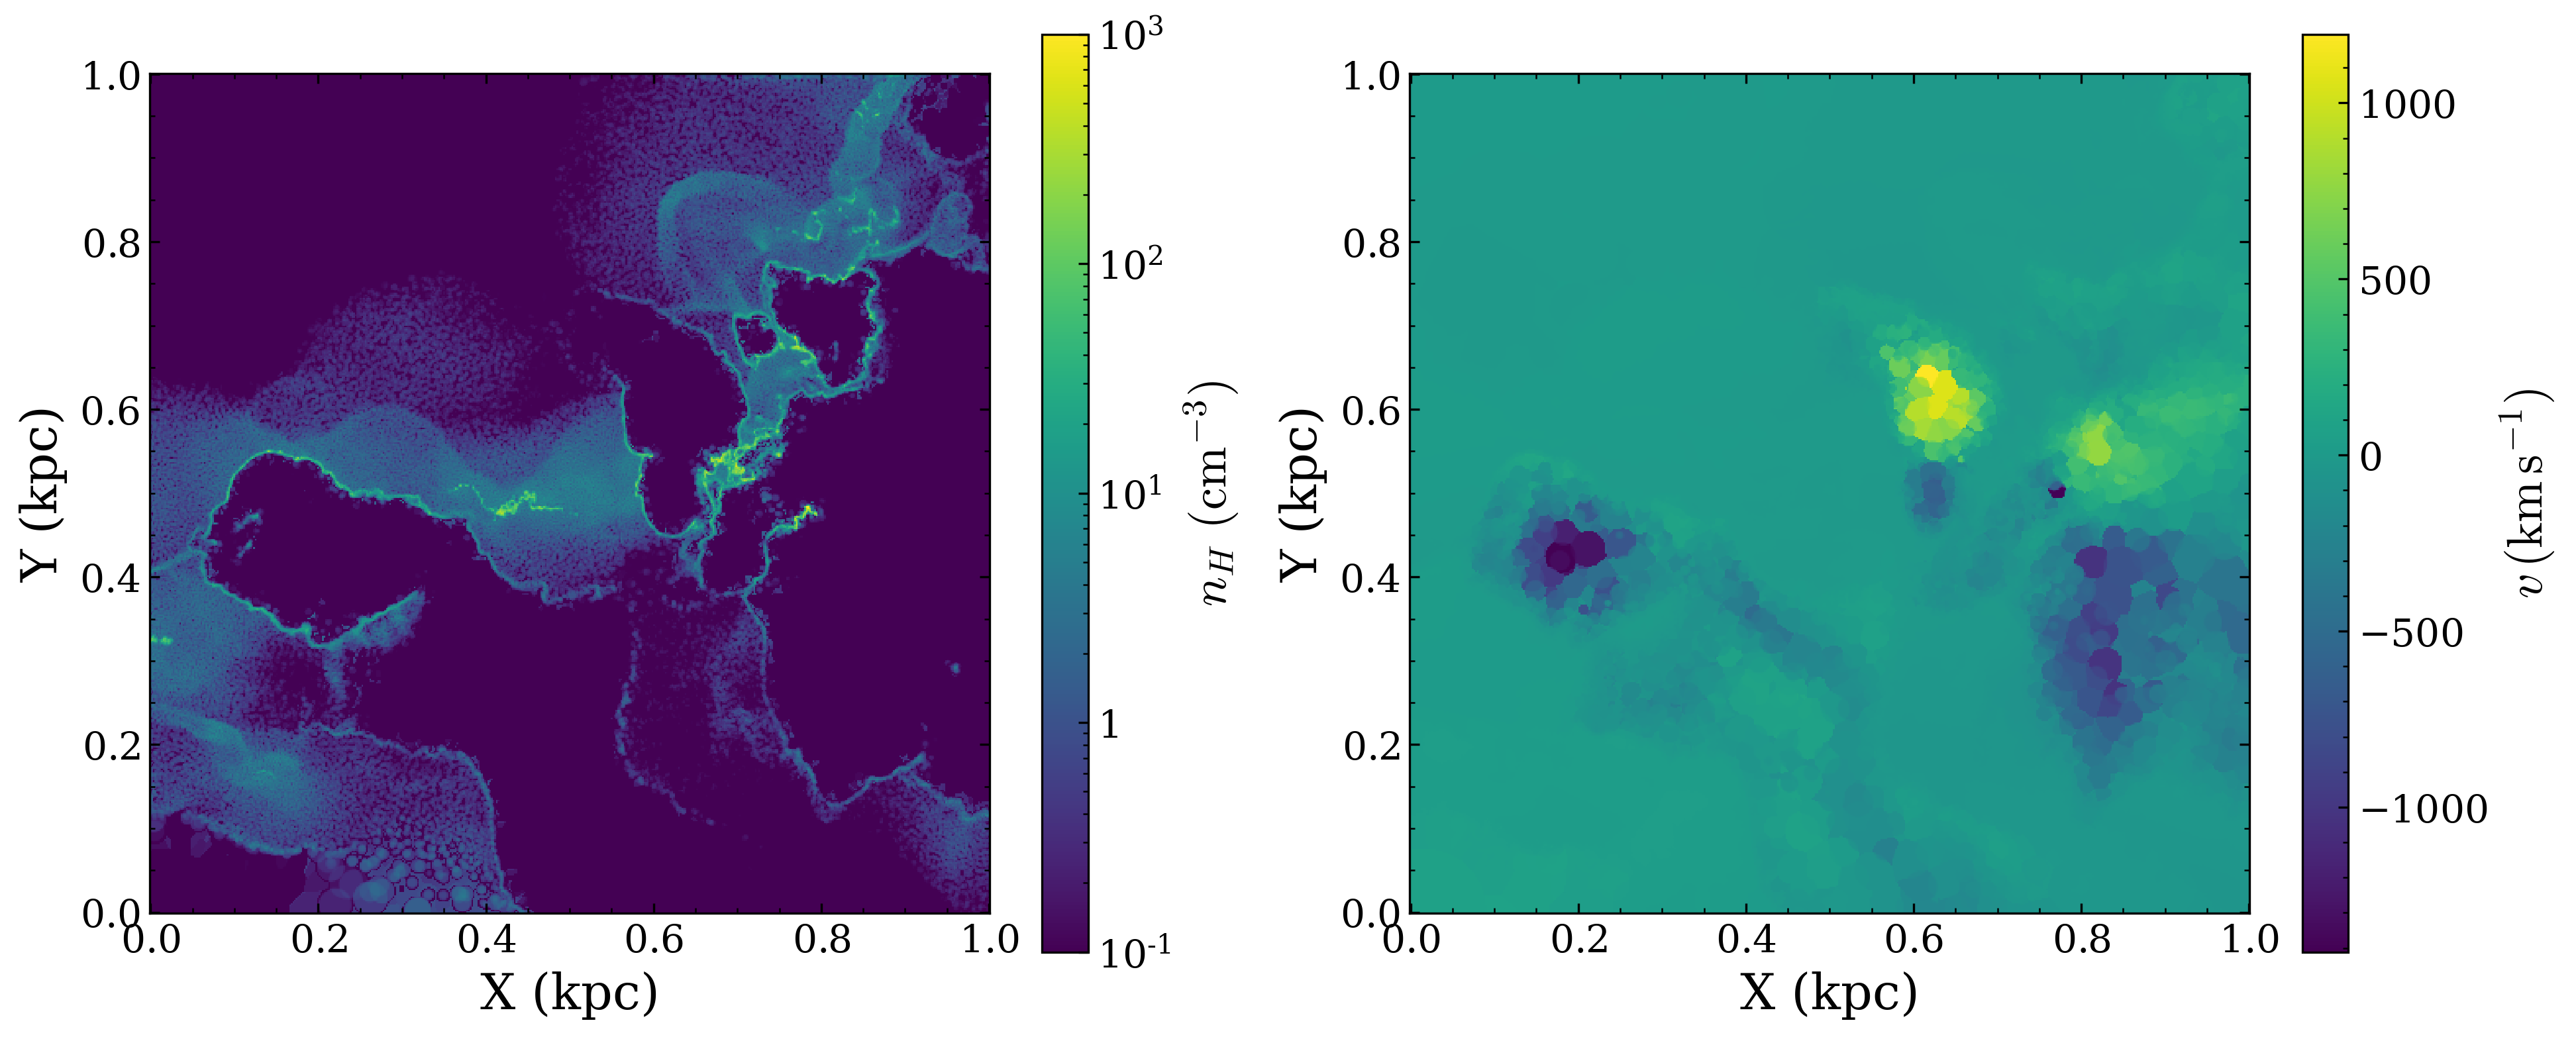

In [6]:
from utils_folding import plot_density2d, plot_velocity2d
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plot_density2d(filled_density[:, :, 256]*300, Lbox=1., Nsize=512, ax=ax[0])
plot_velocity2d(filled_vx[:, :, 256], Lbox=1., Nsize=512, ax=ax[1])
plt.show()

**Dark Art**: `abs`

In [3]:
import numpy as np
a = np.random.rand(512, 512, 512) - 0.5 + (np.random.rand(512, 512, 512) - 0.5) * 1j

In [10]:
import time
t0 = time.perf_counter()
for i in range(5):
  b = np.abs(a)
t = time.perf_counter() - t0
print(t)

2.753285076469183


In [11]:
import time
t0 = time.perf_counter()
for i in range(5):
  b = np.square(a.real) + np.square(a.imag)
t = time.perf_counter() - t0
print(t)

4.787844203412533
